<a href="https://colab.research.google.com/github/aditijorapur/EmotionDetectionUsingNLP/blob/main/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
!pip install datasets

from datasets import load_dataset

# Assuming you've uploaded the files to the root directory of your Colab environment
emotions_train = load_dataset("csv", data_files="train.csv", sep=";", names=["text", "label"])
emotions_valid = load_dataset("csv", data_files="validation.csv", sep=";", names=["text", "label"])
emotions_test = load_dataset("csv", data_files="test.csv", sep=";", names=["text", "label"])


In [ ]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [ ]:
emotions_valid

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotions_train.set_format(type="pandas")
df = emotions_train["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


There are 6 categories


<Axes: ylabel='label'>

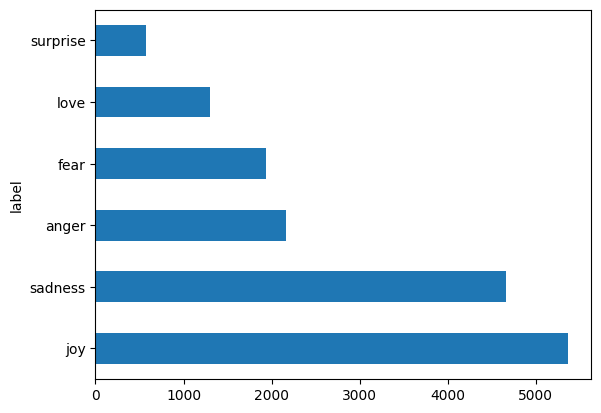

In [ ]:
print("There are",df.label.nunique(), "categories")
df.label.value_counts().plot.barh()

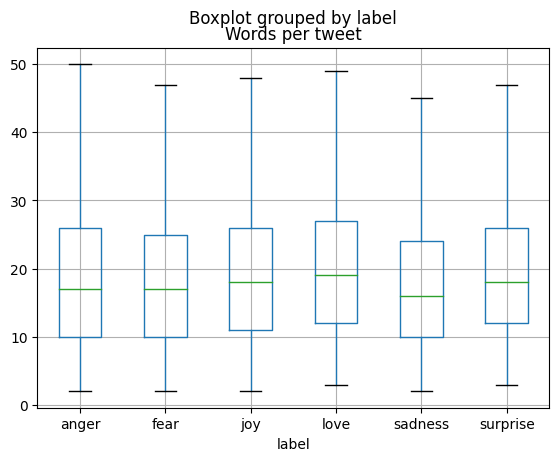

In [ ]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label", showfliers=False)
plt.show()


In [ ]:
emotions_train.reset_format()

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
text = "Tokenizing text is a core task of NLP"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [ ]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp [SEP]'

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
#tokenizer function
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
emotions_train["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
print(tokenize(emotions_train["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
train_encoded = emotions_train.map(tokenize, batched=True, batch_size=None)
valid_encoded = emotions_valid.map(tokenize, batched=True, batch_size=None)
test_encoded = emotions_test.map(tokenize, batched=True, batch_size=None)

In [ ]:
train_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
})

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [ ]:
label_encoded = label_encoder.fit_transform(train_encoded["train"]["label"])
train_encoded["train"] = train_encoded["train"].add_column("label_encoded", label_encoded)

In [ ]:
label_encoded = label_encoder.fit_transform(valid_encoded["train"]["label"])
valid_encoded["train"] = valid_encoded["train"].add_column("label_encoded", label_encoded)

In [ ]:
label_encoded = label_encoder.fit_transform(test_encoded["train"]["label"])
test_encoded["train"] = test_encoded["train"].add_column("label_encoded", label_encoded)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Y_train = label_encoder.fit_transform(emotions_train["train"]["label"])
Y_valid = label_encoder.transform(emotions_valid["train"]["label"])


In [ ]:
train_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'label_encoded'],
        num_rows: 16000
    })
})

In [ ]:
valid_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'label_encoded'],
        num_rows: 2000
    })
})

In [ ]:
test_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'label_encoded'],
        num_rows: 2000
    })
})

In [ ]:
from transformers import TFAutoModel

model_ckpt = "distilbert-base-uncased"
model = TFAutoModel.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBe

In [ ]:
text = ["this is a test", "what is this"]
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="tf")
inputs

{'input_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 2023, 2003, 1037, 3231,  102],
       [ 101, 2054, 2003, 2023,  102,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0]], dtype=int32)>}

In [ ]:
inputs["input_ids"].shape

TensorShape([2, 6])

In [ ]:
inputs.input_ids

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 2023, 2003, 1037, 3231,  102],
       [ 101, 2054, 2003, 2023,  102,    0]], dtype=int32)>

In [ ]:
inputs.attention_mask

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0]], dtype=int32)>

In [ ]:
model(inputs)

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.15651296, -0.18619649,  0.05277671, ..., -0.11881149,
          0.06620622,  0.5470156 ],
        [-0.3575139 , -0.6483557 , -0.06178988, ..., -0.30401954,
          0.35076845,  0.5220684 ],
        [-0.27718464, -0.44594443,  0.18184277, ..., -0.09477955,
         -0.00757503,  0.9958282 ],
        [-0.28408542, -0.39167687,  0.37525564, ..., -0.21505752,
         -0.11725172,  1.0526477 ],
        [ 0.26608247, -0.50936383, -0.3180132 , ..., -0.42029813,
          0.01444188, -0.21489492],
        [ 0.94406074,  0.01117295, -0.47139442, ...,  0.143947  ,
         -0.7287837 , -0.16194981]],

       [[-0.1127155 , -0.10854324, -0.02729421, ..., -0.13969763,
          0.246918  ,  0.27553093],
        [-0.10600139, -0.26354194, -0.376598  , ...,  0.2189871 ,
          0.272914  , -0.40587294],
        [-0.3754027 , -0.46759775,  0.03081986, ...,  0.00326193,
          0.34338883,  0.51

In [ ]:
model((inputs.input_ids, inputs.attention_mask))

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.15651296, -0.18619649,  0.05277671, ..., -0.11881149,
          0.06620622,  0.5470156 ],
        [-0.3575139 , -0.6483557 , -0.06178988, ..., -0.30401954,
          0.35076845,  0.5220684 ],
        [-0.27718464, -0.44594443,  0.18184277, ..., -0.09477955,
         -0.00757503,  0.9958282 ],
        [-0.28408542, -0.39167687,  0.37525564, ..., -0.21505752,
         -0.11725172,  1.0526477 ],
        [ 0.26608247, -0.50936383, -0.3180132 , ..., -0.42029813,
          0.01444188, -0.21489492],
        [ 0.94406074,  0.01117295, -0.47139442, ...,  0.143947  ,
         -0.7287837 , -0.16194981]],

       [[-0.1127155 , -0.10854324, -0.02729421, ..., -0.13969763,
          0.246918  ,  0.27553093],
        [-0.10600139, -0.26354194, -0.376598  , ...,  0.2189871 ,
          0.272914  , -0.40587294],
        [-0.3754027 , -0.46759775,  0.03081986, ...,  0.00326193,
          0.34338883,  0.51

In [ ]:
outputs = model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.15651296, -0.18619649,  0.05277671, ..., -0.11881149,
          0.06620622,  0.5470156 ],
        [-0.3575139 , -0.6483557 , -0.06178988, ..., -0.30401954,
          0.35076845,  0.5220684 ],
        [-0.27718464, -0.44594443,  0.18184277, ..., -0.09477955,
         -0.00757503,  0.9958282 ],
        [-0.28408542, -0.39167687,  0.37525564, ..., -0.21505752,
         -0.11725172,  1.0526477 ],
        [ 0.26608247, -0.50936383, -0.3180132 , ..., -0.42029813,
          0.01444188, -0.21489492],
        [ 0.94406074,  0.01117295, -0.47139442, ...,  0.143947  ,
         -0.7287837 , -0.16194981]],

       [[-0.1127155 , -0.10854324, -0.02729421, ..., -0.13969763,
          0.246918  ,  0.27553093],
        [-0.10600139, -0.26354194, -0.376598  , ...,  0.2189871 ,
          0.272914  , -0.40587294],
        [-0.3754027 , -0.46759775,  0.03081986, ...,  0.00326193,
          0.34338883,  0.51

In [ ]:
outputs.last_hidden_state.shape

TensorShape([2, 6, 768])

In [ ]:
outputs.last_hidden_state[:, 0]

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.15651296, -0.18619649,  0.05277671, ..., -0.11881149,
         0.06620622,  0.5470156 ],
       [-0.1127155 , -0.10854324, -0.02729421, ..., -0.13969763,
         0.246918  ,  0.27553093]], dtype=float32)>

In [ ]:
emotions_train["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
print(emotions_train["train"]["text"][0])
print("Label:" ,emotions_train["train"]["label"][0])

i didnt feel humiliated
Label: sadness


In [ ]:
train_encoded.reset_format()
def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True,
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [ ]:
emotions_hidden_train = train_encoded.map(extract_hidden_states, batched=True, batch_size=512)
emotions_hidden_train

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'label_encoded', 'hidden_state'],
        num_rows: 16000
    })
})

In [ ]:
emotions_hidden_valid = valid_encoded.map(extract_hidden_states, batched=True, batch_size=512)
emotions_hidden_valid

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'label_encoded', 'hidden_state'],
        num_rows: 2000
    })
})

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden_train["train"]["hidden_state"])
X_train.shape

(16000, 768)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoded = LabelEncoder()

Y_train = label_encoded.fit_transform(emotions_hidden_train["train"]["label"])
Y_valid = label_encoded.fit_transform(emotions_hidden_valid["train"]["label"])

In [ ]:
Y_train.shape

(16000,)

In [ ]:
X_valid = np.array(emotions_hidden_valid["train"]["hidden_state"])
X_valid.shape

(2000, 768)

In [ ]:
Y_valid.shape

(2000,)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertFor

In [ ]:
#let's convert our dataset into the tf.data.Dataset format.
tokenizer_columns = tokenizer.model_input_names
tokenizer_columns

['input_ids', 'attention_mask']

In [ ]:
from transformers import DataCollatorWithPadding

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 32

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
train_encoded["train"]["label_encoded"][:5]

[4, 4, 0, 3, 0]

In [ ]:
tf_train_dataset = train_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label_encoded"],
    shuffle=True,
    batch_size=batch_size
)


/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
tf_valid_dataset = valid_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label_encoded"],
    shuffle=True,
    batch_size=batch_size
)


In [ ]:
tf_test_dataset = test_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    shuffle=False,
    batch_size=batch_size
)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

In [ ]:
tf_train_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 87), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 87), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=2)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
500/500 [==============================] - 97s 105ms/step - loss: 0.4375 - sparse_categorical_accuracy: 0.8497 - val_loss: 0.1871 - val_sparse_categorical_accuracy: 0.9285
Epoch 2/2
500/500 [==============================] - 40s 81ms/step - loss: 0.1369 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.1502 - val_sparse_categorical_accuracy: 0.9370


In [ ]:
test_encoded["train"]["input_ids"][0]

[101,
 10047,
 3110,
 2738,
 11083,
 2061,
 10047,
 2025,
 2200,
 12479,
 2157,
 2085,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
output_logits = model.predict([test_encoded["train"]["input_ids"][3], test_encoded["train"]["attention_mask"][3]]).logits
pred_labels = np.argmax(output_logits)
pred_labels

1/1 [==============================] - 3s 3s/step


2

In [ ]:
pred_labels

2

In [ ]:
output_logits = model.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

63/63 [==============================] - 5s 23ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_encoded["train"]["label_encoded"], pred_labels))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       275
           1       0.83      0.97      0.89       224
           2       0.98      0.93      0.95       695
           3       0.80      0.93      0.86       159
           4       0.97      0.96      0.97       581
           5       0.83      0.67      0.74        66

    accuracy                           0.93      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.94      0.93      0.93      2000



In [ ]:
labels = list(set(test_encoded["train"]["label_encoded"]))

In [ ]:
label_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

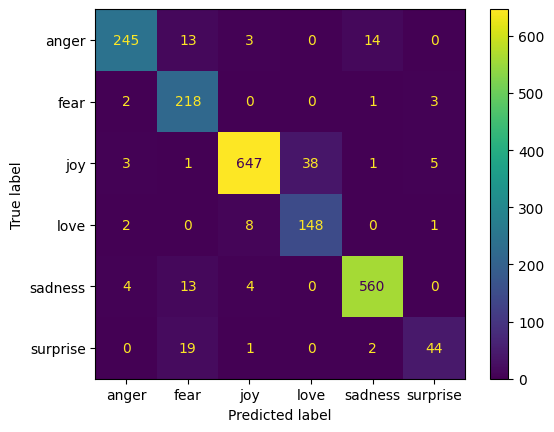

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(test_encoded["train"]["label_encoded"], pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()

In [ ]:
pred_labels[0].shape

()

In [ ]:
for i in range(20):
    print(emotions_test["train"]["text"][i] ,"\t\t ", emotions_test["train"]["label"][i], "\t ", label_encoder.inverse_transform([pred_labels[i]]), "\n")

im feeling rather rotten so im not very ambitious right now 		  sadness 	  ['sadness'] 

im updating my blog because i feel shitty 		  sadness 	  ['sadness'] 

i never make her separate from me because i don t ever want her to feel like i m ashamed with her 		  sadness 	  ['sadness'] 

i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived 		  joy 	  ['joy'] 

i was feeling a little vain when i did this one 		  sadness 	  ['sadness'] 

i cant walk into a shop anywhere where i do not feel uncomfortable 		  fear 	  ['fear'] 

i felt anger when at the end of a telephone call 		  anger 	  ['anger'] 

i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia 		  joy 	  ['joy'] 

i like to have the same breathless feeling as a reader eager to see what will happen next 		 